In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch


In [2]:
# Load the dataset
file_path = 'Total_Crops.csv'
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85260 entries, 0 to 85259
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mandiid          85260 non-null  int64 
 1   cropid           85260 non-null  int64 
 2   cropname         85260 non-null  object
 3   mandiname        85260 non-null  object
 4   arrivalquantity  85260 non-null  int64 
 5   maximumprice     85260 non-null  int64 
 6   minimumprice     85260 non-null  int64 
 7   modalprice       85260 non-null  int64 
 8   date             85260 non-null  object
dtypes: int64(6), object(3)
memory usage: 5.9+ MB


In [4]:
# Ensure the dataset contains 'cropid' and 'mandiid' columns
if 'cropid' in data.columns and 'mandiid' in data.columns:
    # Get the count of entries for each combination of 'cropid' and 'mandiid'
    combination_counts = data.groupby(['cropid', 'mandiid']).size().reset_index(name='count')

    # Sort the combinations by count in descending order
    combination_counts_sorted = combination_counts.sort_values(by='count', ascending=False)

    # Get the top 10 unique entries based on the counts
    top_10_unique_combinations = combination_counts_sorted.head(10)

    # Print the top 10 unique combinations without indexes
    print(top_10_unique_combinations.to_string(index=False))
else:
    print("The dataset does not contain the required 'cropid' and 'mandiid' columns.")

 cropid  mandiid  count
      7      227    986
     13      359    959
      7      981    934
      1     1122    926
      1     1129    902
      1     1142    902
      7     1331    877
      1     1235    863
     13      167    859
      1     1212    859


In [5]:
# Prompt for cropid and mandiid
cropid = int(input("Enter cropid: "))
mandiid_input = input("Enter mandiid (leave blank for all mandis): ")

Enter cropid:  1
Enter mandiid (leave blank for all mandis):  1129


In [6]:
# Filter data based on inputs
if mandiid_input.strip() == "":
    filtered_data = data[data['cropid'] == cropid]
else:
    mandiid = int(mandiid_input)
    filtered_data = data[(data['cropid'] == cropid) & (data['mandiid'] == mandiid)]

In [7]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 902 entries, 5 to 85237
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mandiid          902 non-null    int64 
 1   cropid           902 non-null    int64 
 2   cropname         902 non-null    object
 3   mandiname        902 non-null    object
 4   arrivalquantity  902 non-null    int64 
 5   maximumprice     902 non-null    int64 
 6   minimumprice     902 non-null    int64 
 7   modalprice       902 non-null    int64 
 8   date             902 non-null    object
dtypes: int64(6), object(3)
memory usage: 70.5+ KB


In [8]:
# Remove outliers using Z-score method
z_scores = np.abs(stats.zscore(filtered_data['modalprice']))
filtered_data = filtered_data[z_scores < 1]
print(f"Data size after removing outliers: {filtered_data.shape}")

Data size after removing outliers: (566, 9)


In [9]:
# Check if filtered data is not empty
if filtered_data.empty:
    print("No data found for the given cropid and mandiid.")
else:
    cropname = filtered_data['cropname'].iloc[0]
    mandiname = filtered_data['mandiname'].iloc[0] if mandiid_input.strip() != "" else "All Mandis"

    # Prepare data for training
    dataset = filtered_data['modalprice'].values  # Assuming 'modalprice' is the target variable
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split into train and test sets (80% training, 20% testing)
    train_size = int(len(dataset) * 0.8)
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # Create a dataset function
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    look_back = 5  # Increase look_back to consider more past days
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [10]:
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(1, look_back)))

        # Tune the number of units in the LSTM layers
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), return_sequences=(i < 2)))
            model.add(LeakyReLU(negative_slope=0.01))
            model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)))

        model.add(Dense(1))
        
        # Tune the learning rate for the optimizer
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='mean_squared_error')
        return model

# Instantiate the hypermodel
hypermodel = MyHyperModel()

# Instantiate the tuner and perform hyperparameter tuning
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

tuner.search(trainX, trainY, epochs=200, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of layers is {best_hps.get('num_layers')}.
The optimal number of units in each layer are:
{[best_hps.get('units_' + str(i)) for i in range(best_hps.get('num_layers'))]}.
The optimal dropout rates are:
{[best_hps.get('dropout_' + str(i)) for i in range(best_hps.get('num_layers'))]}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
model.fit(trainX, trainY, epochs=300, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=2)

Reloading Tuner from my_dir\lstm_tuning\tuner0.json

The optimal number of layers is 3.
The optimal number of units in each layer are:
[50, 50, 150].
The optimal dropout rates are:
[0.30000000000000004, 0.30000000000000004, 0.4].
The optimal learning rate is 0.004591848176101869.

Epoch 1/300
13/13 - 14s - 1s/step - loss: 0.1725 - val_loss: 0.0865
Epoch 2/300
13/13 - 0s - 19ms/step - loss: 0.0745 - val_loss: 0.0805
Epoch 3/300
13/13 - 0s - 13ms/step - loss: 0.0694 - val_loss: 0.0592
Epoch 4/300
13/13 - 0s - 13ms/step - loss: 0.0624 - val_loss: 0.0537
Epoch 5/300
13/13 - 0s - 18ms/step - loss: 0.0544 - val_loss: 0.0370
Epoch 6/300
13/13 - 0s - 13ms/step - loss: 0.0550 - val_loss: 0.0443
Epoch 7/300
13/13 - 0s - 21ms/step - loss: 0.0511 - val_loss: 0.0359
Epoch 8/300
13/13 - 0s - 12ms/step - loss: 0.0525 - val_loss: 0.0400
Epoch 9/300
13/13 - 0s - 14ms/step - loss: 0.0503 - val_loss: 0.0371
Epoch 10/300
13/13 - 0s - 14ms/step - loss: 0.0492 - val_loss: 0.0374
Epoch 11/300
13/13 - 0s - 11

In [11]:
# Function for generating predictions
def predict_future(model, testX, days, look_back):
    predictions = []
    current_input = testX[-1]  # Start with the last input from the test set
    current_input = np.reshape(current_input, (1, 1, look_back))
    for _ in range(days):
        prediction = model.predict(current_input)
        predictions.append(prediction[0][0])
        current_input = np.append(current_input[:, :, 1:], prediction).reshape((1, 1, look_back))
    return predictions

In [12]:
# Prompt for number of days for prediction
days = int(input("Enter number of days to predict: "))

Enter number of days to predict:  10


In [13]:
# Generate predictions for the specified number of days
predictions = predict_future(model, testX, days, look_back)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Prepare data for visualization with fixed start date
start_date = pd.to_datetime('2024-03-04')
prediction_dates = pd.date_range(start=start_date, periods=days)
prediction_series = pd.Series(predictions.flatten(), index=prediction_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


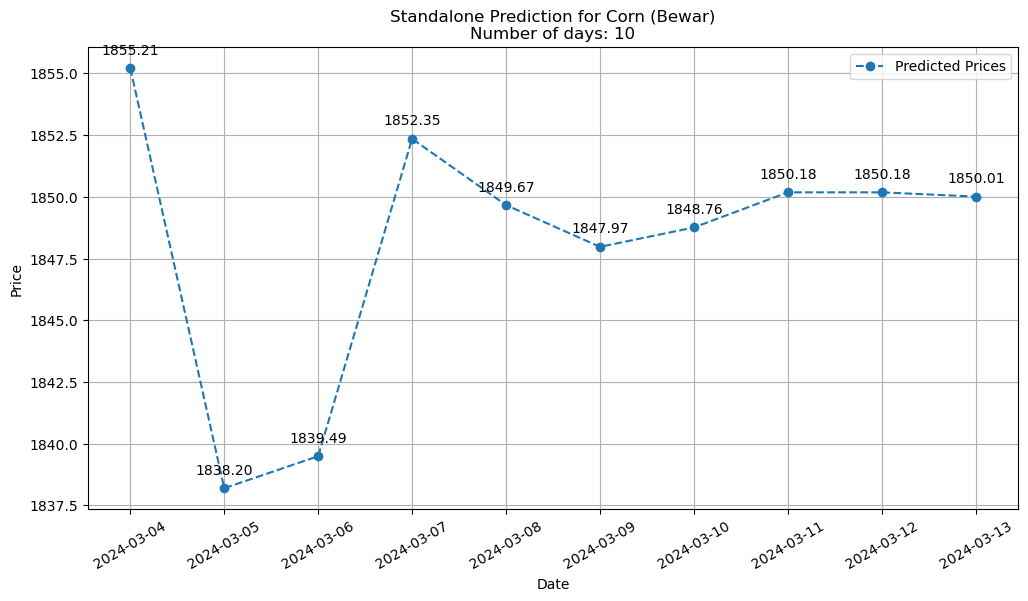

In [14]:
# Standalone prediction plot
plt.figure(figsize=(12, 6))
plt.plot(prediction_series, label='Predicted Prices', linestyle='--', marker='o')
for i, txt in enumerate(predictions):
    plt.annotate(f'{txt[0]:.2f}', (prediction_series.index[i], prediction_series.values[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title(f'Standalone Prediction for {cropname} ({mandiname})\nNumber of days: {days}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

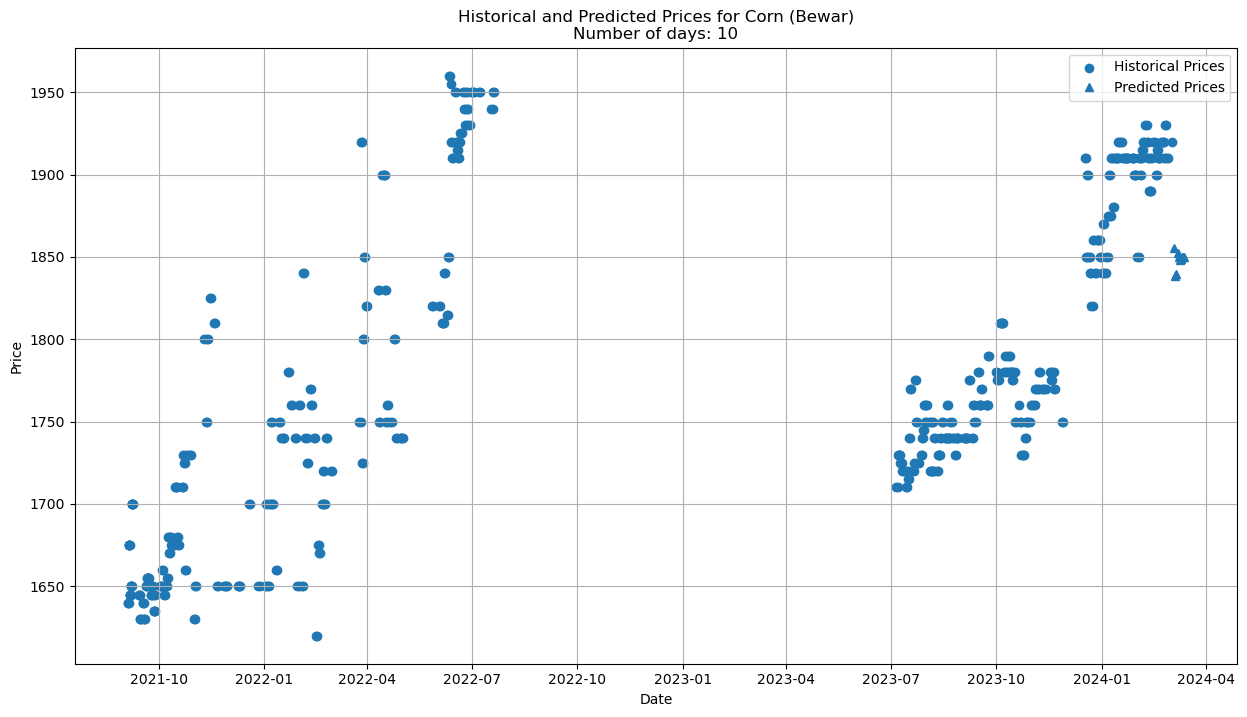

In [15]:
# Combined plot of historical data and predictions
historical_series = pd.Series(filtered_data['modalprice'].values, index=pd.to_datetime(filtered_data['date']))
plt.figure(figsize=(15, 8))
plt.scatter(historical_series.index, historical_series.values, label='Historical Prices')
plt.plot(prediction_series, label='Predicted Prices', linestyle='', marker='^')
plt.title(f'Historical and Predicted Prices for {cropname} ({mandiname})\nNumber of days: {days}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Convert predictions to a DataFrame
predicted_df = pd.DataFrame(predictions, columns=['predicted_price'])

# Save the predictions to a CSV file
output_path = f'Predicted_{cropname}_NeuralNetwork.csv'
predicted_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

Predictions saved to Predicted_Corn_NeuralNetwork.csv
